In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
from statsmodels.datasets import grunfeld
from linearmodels.panel  import PanelOLS
import pandas as pd
import build_data_functions as bdf
import plot_data_functions as pdf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import model_functions as mf
import plot_model_functions as pmf
import panelOLS_models 
import spatial_error_model as sem
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import pycountry
import os
from sys import argv
import json
from collections import defaultdict
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from scipy.stats import normaltest

In [2]:
#first, last = argv
#years = list(range(first, last))
years = list(range(2005, 2017))

In [3]:
y = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/resident_foreigners_norm.csv", sep = "\t", index_col=0)
y = y.groupby(["Province", "Country", "Year"], as_index=False)["Value"].sum()
y = bdf.pivot(y, "Country", "Value")

resident_foreigners_norm = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/resident_foreigners_norm.csv")

#unesco_demo = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/countries_info.csv", sep = "\t", index_col=[0,1])

In [4]:
# To get the Italy info we need to sum the 5 Italian zones
zones = list(pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/x_zones.csv", sep = "\t", index_col=["Province", "Year"]).index.levels[0])

for t in y.index.levels[1]:
    y.loc[("Italia", t), :] = y.loc[(zones, t), :].sum()

In [5]:
temp = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/x_zones.csv", sep = "\t", index_col=["Province", "Year"])
xs = pd.DataFrame(columns=["Province", "Year"]+temp.columns.tolist())
xs = xs.set_index(["Province","Year"])

for t in temp.index.levels[1]:
    xs.loc[("Italia", t), :] = temp.loc[(zones, t), :].sum()

In [7]:
directory = "/home/sara/Documents/Immigration/Shared_models/Plot_%d_%d" %(years[0], years[-1])
y_hat = pd.read_table(directory+"/predicted_italia.csv", sep = "\t", index_col=["Year", "Country"])

In [8]:
countries_list = ["Romania", "Morocco", "Albania", "Tunisia", "Egypt", "Ecuador", "Peru", "China", "Philippines"]
countries_list_iso3 = [pycountry.countries.get(name=country).alpha_3 for country in countries_list]

I = "Italia"

In [9]:
c = countries_list_iso3[0]

In [10]:
single_beta = defaultdict(list)
z = "Centro"
for z in zones:
    temp = list((y.loc[(z, years[:]), c].values  / y_hat.loc[(years[:], c), "Predicted"].values) * (y.loc[(I, [y -1 for y in years]), c].values / y.loc[(z, [y -1 for y in years]), c].values))
    single_beta[z] = temp

In [ ]:
y_italia_pred = y.copy()
for country in countries_list_iso3:
    y_italia_pred.loc[("Italia", years), country] = np.array(y_hat.loc[(slice(None), country), "Predicted"].values, dtype=np.float32)

In [60]:
idx = pd.MultiIndex.from_product([years, 
                                  countries_list_iso3],
                                 names=["Year", "Country"])
col = zones
beta_est = pd.DataFrame('-', idx, col)

for c in countries_list_iso3:
    for z in zones:
        temp = list((y.loc[(z, years[:]), c].values  / y_hat.loc[(years[:], c), "Predicted"].values) * (y.loc[(I, [y -1 for y in years]), c].values / y.loc[(z, [y -1 for y in years]), c].values))
        beta_est.loc[(slice(None), c), z] = temp

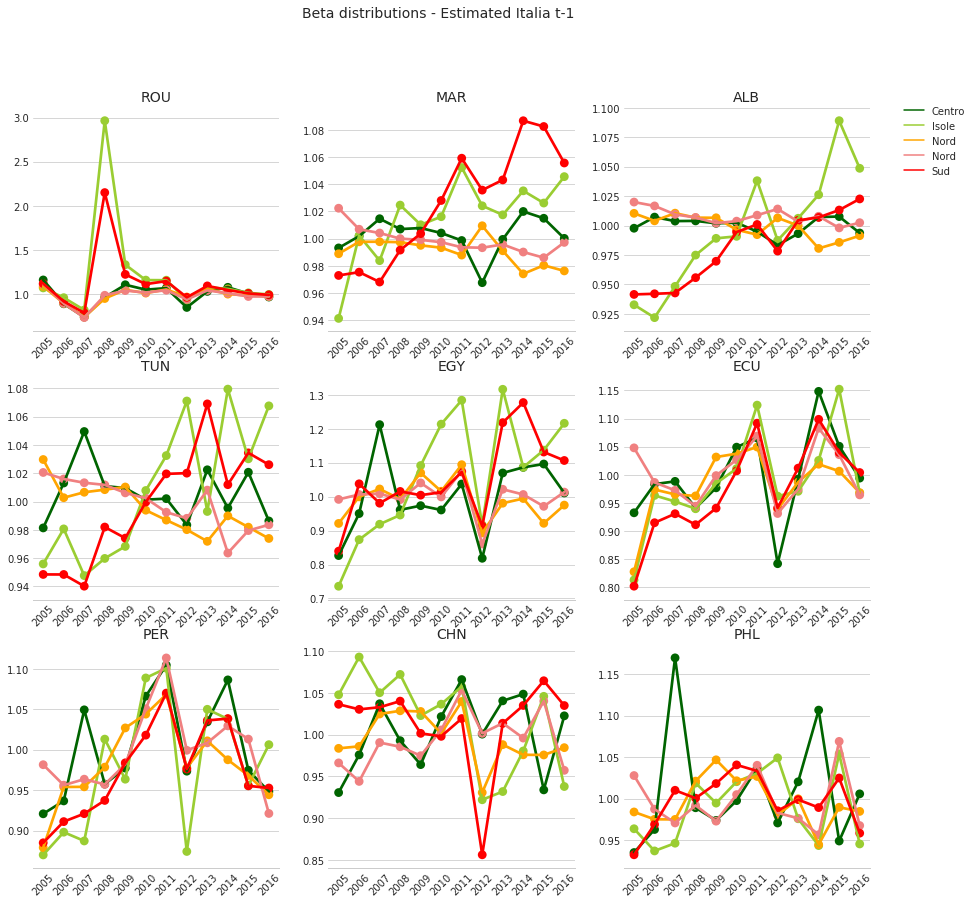

In [61]:
palette = ['blue', 'darkgreen', 'yellowgreen', 'orange', 'lightcoral', 'red', 'paleturquoise', 'deepskyblue', 'mediumpurple', 'fuchsia']
multiple_series(beta_est, countries_list_iso3, years, zones, plt.figure(1, figsize=(15,14)), 331, 45, palette, None, "Beta distributions - Estimated Italia t-1", False, directory+"/regression_model_italy")

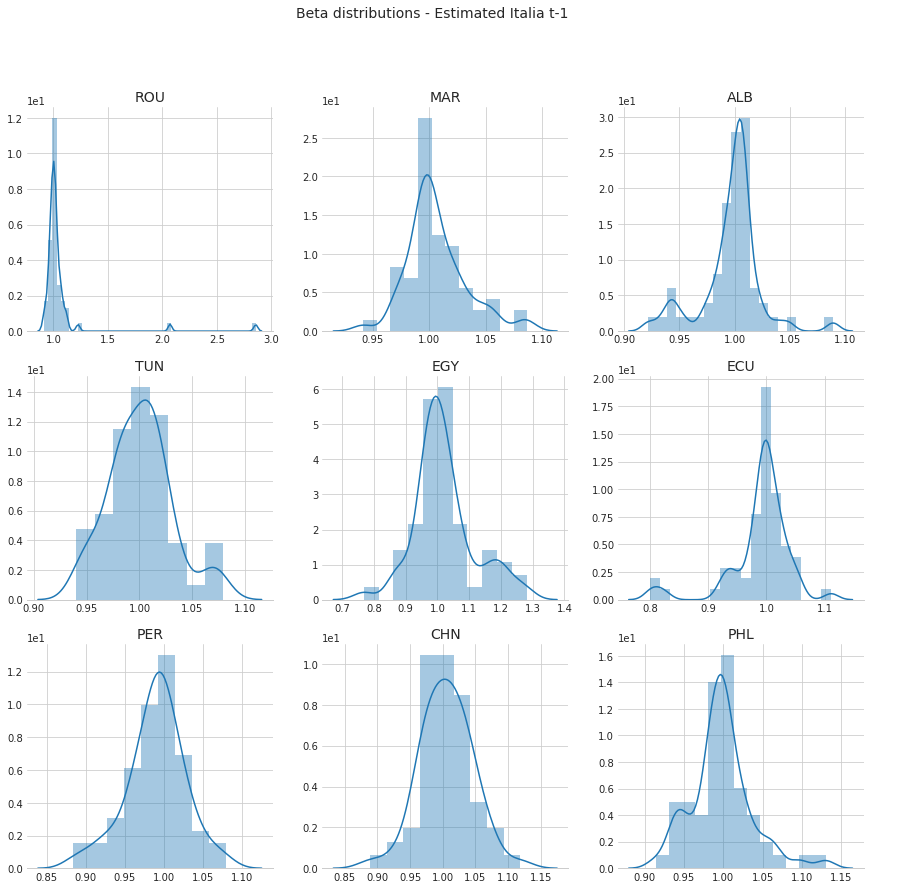

In [94]:
hist(beta_est, countries_list_iso3, years, zones, plt.figure(1, figsize=(15,14)), 331, 45, palette, None, "Beta distributions - Estimated Italia t-1", False, directory+"/regression_model_italy")

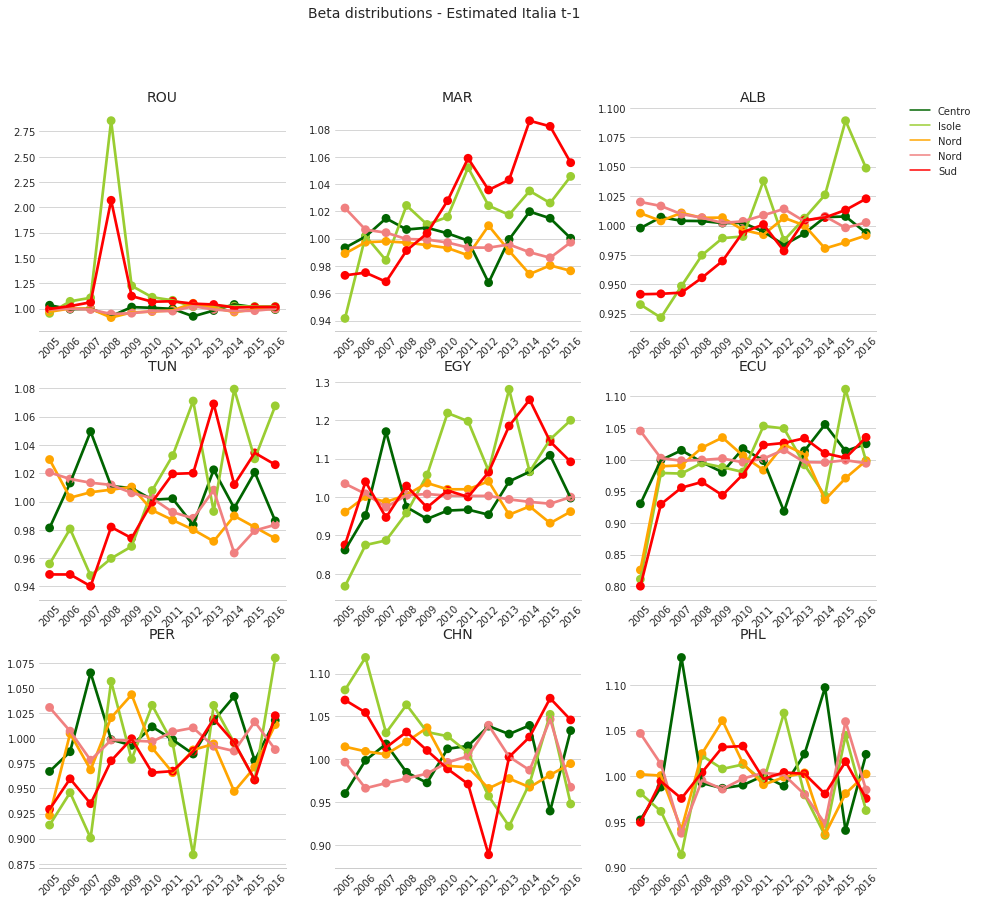

In [65]:
beta = pd.DataFrame('-', idx, col)

for c in countries_list_iso3:
    for z in zones:
        temp = list((y.loc[(z, years[:]), c].values  / y.loc[(I, years[:]), c].values) * (y.loc[(I, [y -1 for y in years]), c].values / y.loc[(z, [y -1 for y in years]), c].values))
        beta.loc[(slice(None), c), z] = temp
        
multiple_series(beta, countries_list_iso3, years, zones, plt.figure(1, figsize=(15,14)), 331, 45, palette, None, "Beta distributions - Estimated Italia t-1", False, directory+"/regression_model_italy")

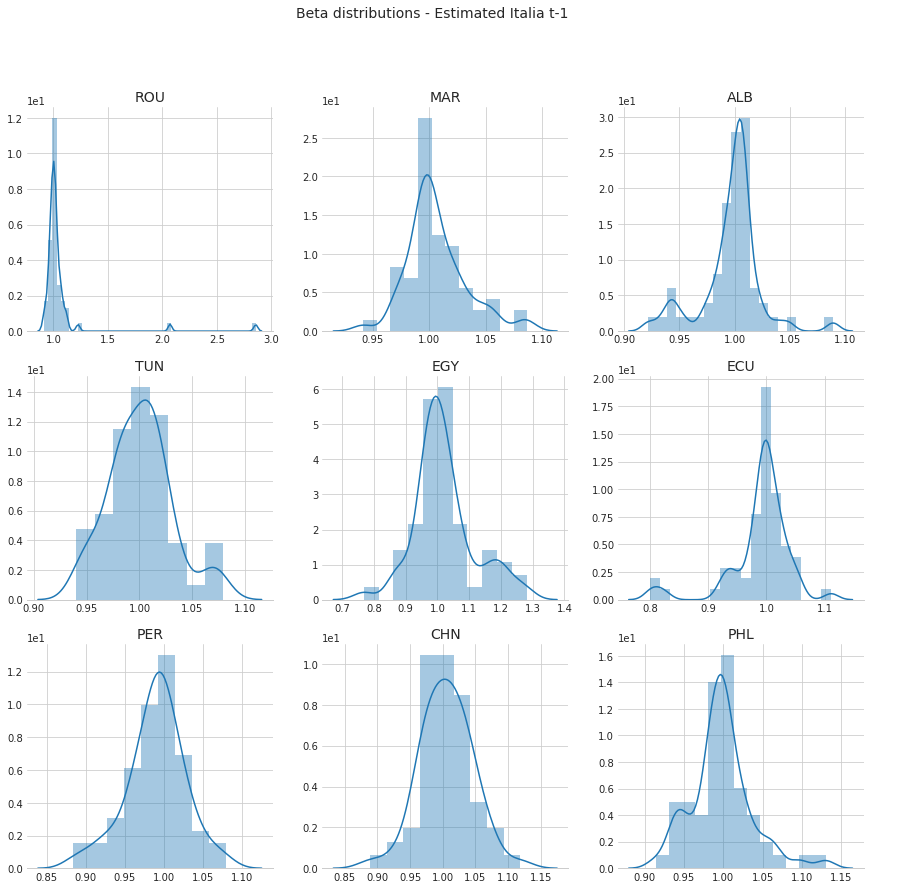

In [93]:
hist(beta, countries_list_iso3, years, zones, plt.figure(1, figsize=(15,14)), 331, 45, palette, None, "Beta distributions - Estimated Italia t-1", False, directory+"/regression_model_italy")

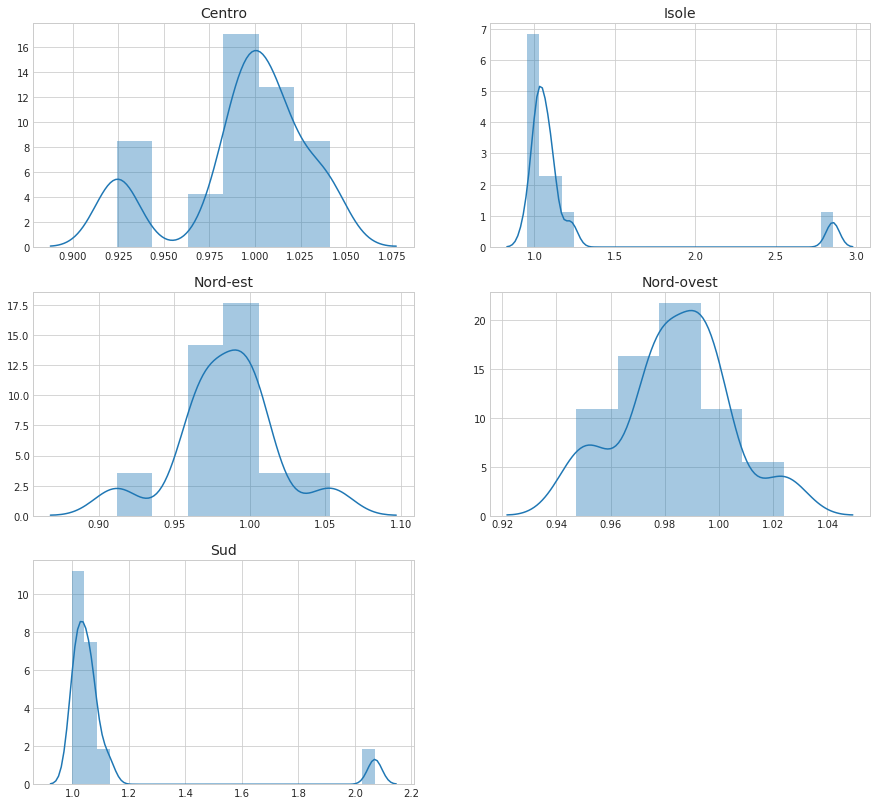

In [92]:
plt_seed = 321
fig = plt.figure(1, figsize=(15,14))
for z in zones:
    ax = fig.add_subplot(plt_seed)
    sns.distplot(list(beta.loc[(slice(None), "ROU"), z].values.flatten()))
    plt.title(z, fontsize = 14)
    plt_seed += 1
plt.show()

In [95]:
y.head()

Country        AFG   AGO      ALB  AND  ARE    ARG  ARM  ATG   AUS   AUT ...   \
Province Year                                                            ...    
Abruzzo  2003  NaN   5.0   6521.0  NaN  NaN  439.0  NaN  1.0  85.0  45.0 ...    
         2004  2.0   7.0   7829.0  1.0  NaN  614.0  4.0  NaN  93.0  51.0 ...    
         2005  3.0   7.0   8854.0  1.0  NaN  579.0  5.0  NaN  89.0  57.0 ...    
         2006  3.0   9.0  10130.0  2.0  1.0  569.0  5.0  NaN  90.0  61.0 ...    
         2007  3.0  11.0  10854.0  1.0  1.0  551.0  5.0  NaN  81.0  57.0 ...    

Country        VCT    VEN  VNM  VUT   WSM  YEM     YUG   ZAF  ZMB  ZWE  
Province Year                                                           
Abruzzo  2003  NaN  355.0  1.0  NaN  10.0  NaN  1539.0  10.0  3.0  1.0  
         2004  NaN  474.0  8.0  NaN   9.0  NaN  1175.0  17.0  3.0  3.0  
         2005  1.0  484.0  9.0  NaN   7.0  NaN  1535.0  16.0  3.0  4.0  
         2006  NaN  489.0  8.0  NaN   8.0  1.0  1539.0  17.0  3.0  4.0  
         2007  NaN  472.0  9.0  NaN   9.0  1.0  1734.0  15.0  2.0  3.0  

[5 rows x 195 columns]

In [91]:
def hist(data_, temp_territories, time_idx, cols, fig, plt_seed, rot, palette, info, title, save, path = ""):

    for r in temp_territories:
        sns.set_style("whitegrid")
        ax = fig.add_subplot(plt_seed)
        legend = []
        sns.distplot(list(beta.loc[(slice(None), r), ].values.flatten()))
        sns.despine(ax=ax, right=True, left=True)
        ax.set_xlabel("")
        #ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        #plt.title(r, fontsize = 14)
        #plt.legend(handles = legend, prop={'size':14}, loc='best')
        plt.title(r, fontsize = 14)
        plt_seed += 1

    if len(temp_territories)%2 == 0:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(1.05, 0.05+int(str(plt_seed)[0])), fancybox=True)
    else:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(2.35, 0.05+int(str(plt_seed)[0])), fancybox=True)

    if len(temp_territories) == 2:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(1.05, .925), fancybox=True)

    if len(temp_territories) == 9:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(1.1, 3.25), fancybox=True)

    fig.suptitle(title, fontsize = 14)
    if save == False:
        plt.show()
    else:
        plt.savefig(path+".png", box_extra_artists=(lgd,), bbox_inches='tight')
    plt.close()

    return(info)

In [87]:
def multiple_series(data_, temp_territories, time_idx, cols, fig, plt_seed, rot, palette, info, title, save, path = ""):

    for r in temp_territories:
        sns.set_style("whitegrid")
        ax = fig.add_subplot(plt_seed)
        legend = []
        for c in cols:
            x_i = [data_.loc[t].loc[r][c] for t in time_idx]
            # Color - always +1 because the first color is for the real value (ax)
            ax= sns.pointplot(y = x_i, x = time_idx, color = palette[cols.index(c)+1])
            legend.append(mlines.Line2D([], [], markersize=15, label=c.split("-")[0], color = palette[cols.index(c)+1]))

        sns.despine(ax=ax, right=True, left=True)
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        #plt.title(r, fontsize = 14)
        #plt.legend(handles = legend, prop={'size':14}, loc='best')
        plt.title(r, fontsize = 14)
        plt_seed += 1

    if len(temp_territories)%2 == 0:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(1.05, 0.05+int(str(plt_seed)[0])), fancybox=True)
    else:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(2.35, 0.05+int(str(plt_seed)[0])), fancybox=True)

    if len(temp_territories) == 2:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(1.05, .925), fancybox=True)

    if len(temp_territories) == 9:
        lgd = plt.legend(handles = legend, loc='center left', bbox_to_anchor=(1.1, 3.25), fancybox=True)

    fig.suptitle(title, fontsize = 14)
    if save == False:
        plt.show()
    else:
        plt.savefig(path+".png", box_extra_artists=(lgd,), bbox_inches='tight')
    plt.close()

    return(info)